<img align="left" src="../images/Guyman-Helmet-On-icon.png">

# L-Met

## Exemple d'utilisation :  Classe *gratingMMFE1D*

Définition d'un réseau diffractant et lancement d'un calcul.

_Pour le moment, LMet ne permet que le calcul MMFE 1D, mais comme tout le reste, l'ajout d'un code de calcul est immédiat._

---

In [1]:
# If LMet is not in your PYTHONPATH
import sys
sys.path.append('../')

In [2]:
%matplotlib inline
from pylab import  *
from math import radians

from LMet.gratingMMFE1D import *

%load_ext autoreload
%autoreload 2

### Détermination des données du réseau et du calcul

- les paramètres à utiliser (grandeurs, matériaux, etc)
- les instructions de construction (analogue aux .gra de libScattero et scatGenious)
- le contexte du calcul

In [3]:
p = {"cd": 30.0,
     "si" : material('file', '../data/IF_{Si100}.txt', name = 'Silicium'),
     "res" : material('file','../data/IF_{NEB22}.txt', name = 'NEB22'),
     "air" : material('constant', 1+0j, name = 'Air')}

instr = """
h = cd/2.0
d= 400.0
initsquare(d, cd, h, si, res, air)
#addlayer(1, 20, cd*1.1, air, res)
"""

context = {"M" : 10,
           "𝜆" : linspace(300, 500.0, 20),
           "angle" : np.array([radians(70)])}


### Création de l'objet $grating$ et lancement du calcul

In [4]:
g = gratingMMFE1D()

g.instructions = instr 
g.parameters = p

g.build()
g.display()

s = g.signature(context)
s.data.head(5)

ec :  [ 0. 15.  0.]
eta :  [[0.     0.4625 0.    ]
 [0.     0.5375 0.    ]]
nulam :  [['Air' 'Air' 'Silicium']
 ['Air' 'NEB22' 'Silicium']
 ['Air' 'Air' 'Silicium']]


,angle,𝜆,M,rp,rs,rp_polar,rs_polar,rpors,Psi,Delta,Is,Ic,S1,S2
0,1.22173,300.000000,10.0,-0.447103,0.349137,0.521957,0.920118,0.567272,0.516007,2.478615,0.528276,-0.676508,0.513091,-0.676508
1,1.22173,310.526316,10.0,-0.419291,0.319025,0.480221,0.911477,0.526860,0.484904,2.491173,0.499420,-0.656382,0.565458,-0.656382
2,1.22173,321.052632,10.0,-0.407806,0.299804,0.459230,0.907299,0.506150,0.468556,2.507655,0.477324,-0.649275,0.592118,-0.649275
3,1.22173,331.578947,10.0,-0.404601,0.282810,0.446835,0.905179,0.493643,0.458549,2.531548,0.454794,-0.650649,0.608126,-0.650649
4,1.22173,342.105263,10.0,-0.407693,0.267169,0.440956,0.904645,0.487435,0.453545,2.561488,0.431755,-0.658849,0.616040,-0.658849


## Affichage du créneau



In [5]:
g.showSVG()

## Optimisation - problème inverse

Prenons une signature et ajoutons lui un bruit gaussien.

/Users/ss211692/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 120582 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ss211692/anaconda3/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:176: RuntimeWarning: Glyph 120582 missing from current font.
  font.load_char(ord(s), flags=flags)


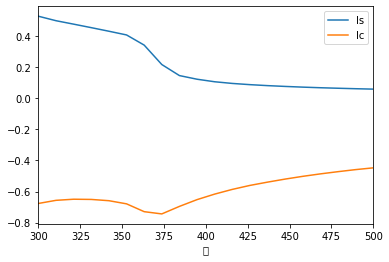

In [6]:
sig = s
sig.isic
sig.data.head(5)
sig.data.plot(x='𝜆', y=['Is', 'Ic'])

Le type de bruit provient de *numpy.random*. Il y a d'autre distributions possibles :

http://docs.scipy.org/doc/numpy/reference/routines.random.html

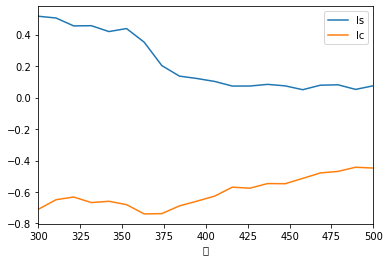

In [8]:
ec = 0.01
sig.data.Is = sig.data.Is + np.random.normal(0, ec, len(sig.data))
sig.data.Ic = sig.data.Ic + np.random.normal(0, ec, len(sig.data))

sig.data.plot(x='𝜆', y=['Is', 'Ic'])

Lancement effectif du problème inverse.

L'optimization vient de *scipy* :

http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

Mais il semble que *jac=False* ne marche pas pour Newton-CG par exemple : comprendre pourquoi.


In [9]:
# Si h n'étais pas lié à cd :
# g.ip(sig, ("cd", "h"),  (300,300), method = "Powell") # params à otimiser, methode, initial guess
         
g.ip(sig, ("cd",),  (30,), method = "Powell") # params à otimiser, methode, initial guess

   direc: array([[1.]])
     fun: 0.07519255305487807
 message: 'Optimization terminated successfully.'
    nfev: 21
     nit: 2
  status: 0
 success: True
       x: array(31.2218764)

In [10]:
g.ip(sig, ("cd",),  (30,), method = "CG") # params à otimiser, methode, initial guess

     fun: 0.07519255594253363
     jac: array([6.33858144e-06])
 message: 'Optimization terminated successfully.'
    nfev: 135
     nit: 4
    njev: 45
  status: 0
 success: True
       x: array([31.22279672])

### Méthode des bibliothèques

Fabrication du tableau des clés (rappel : une biblio est un ensemble de couple (clés, valeur) )

In [12]:
from copy import copy

p = {"cd": 30.0,
     "si" : material("file", "../data/IF_{Si100}.txt"),
     "res" : material("file", "../data/IF_{NEB22}.txt"),
     "air" : material("constant", 1+0j)}

n=3
p_keys = []
for cd in np.linspace(30, 50, n) :
    p_new = copy(p)
    p_new['cd'] = cd 
    p_keys.append(p_new)

p_keys

[{'cd': 30.0,
  'si': <LMet.material.material at 0x13202a7908>,
  'res': <LMet.material.material at 0x13200b6710>,
  'air': <LMet.material.material at 0x13202a7470>},
 {'cd': 40.0,
  'si': <LMet.material.material at 0x13202a7908>,
  'res': <LMet.material.material at 0x13200b6710>,
  'air': <LMet.material.material at 0x13202a7470>},
 {'cd': 50.0,
  'si': <LMet.material.material at 0x13202a7908>,
  'res': <LMet.material.material at 0x13200b6710>,
  'air': <LMet.material.material at 0x13202a7470>}]

Lancement du calcul.

In [13]:
g = gratingMMFE1D()

g.instructions = instr 
g.libparameters = p_keys
g.context = context
    

l = g.library()

l[0]

array([-0.44710319,  0.34913702, -0.41929093,  0.31902471, -0.40780589,
        0.29980408, -0.40460091,  0.28280984, -0.40769345,  0.26716872,
       -0.4216861 ,  0.25330863, -0.45812004,  0.21512391, -0.45582085,
        0.13331547, -0.40825452,  0.08594823, -0.37287608,  0.07032771,
       -0.34624958,  0.05990024, -0.32479155,  0.05313813, -0.30736543,
        0.04828759, -0.29340039,  0.04449102, -0.28078616,  0.04138973,
       -0.26963261,  0.03871231, -0.25983654,  0.03644411, -0.25114487,
        0.03454091, -0.24319022,  0.03280318, -0.23644375,  0.03128626])

Recherche des k-PPV :

Disons que la première signature de la bibliothèque est la signature acquise.

In [14]:
s_exp = l[0] 

from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(l)
distances, indices = nbrs.kneighbors([s_exp])    

distances, indices

(array([[0.        , 0.15094013]]), array([[0, 1]]))


## Utilisation avancée

Il est possible de fabriquer ses propres fonctions de constructions.

In [15]:
g2 = gratingMMFE1D()

g2.buildinstructions += """

def addlayer2(i, e, cd, air, mat) :
    global ec, eta, nulam
       
    ec = np.insert(ec, i, e)
    eta = np.insert(eta, i, np.array([0.5-cd/d, 0.5+cd/d]), 1) # d'ou la necessité de bien faire les eta, nulam...
    nulam = np.insert(nulam, i, np.array([air, mat, air]),1)
   
"""

instr = """
h = cd/2.0
d= 400
initsquare(d, cd, h, si, res, air)
addlayer2(1, 20, cd*1.1, air, res)

"""
g2.instructions = instr
g2.parameters = p
g2.build()
g2.showSVG()
